<a href="https://colab.research.google.com/github/aalhayali/Diffusion_models_from_scratch/blob/main/Diffusion_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install libraries

!pip install --quiet diffusers==0.8.0
!pip install --quiet transformers scipy ftfy
!pip install --quiet "ipywidgets>=7,<8"

     |████████████████████████████████| 433 kB 4.6 MB/s 
     |████████████████████████████████| 182 kB 24.0 MB/s 
     |████████████████████████████████| 5.8 MB 5.3 MB/s 
     |████████████████████████████████| 53 kB 1.2 MB/s 
     |████████████████████████████████| 7.6 MB 32.3 MB/s 
     |████████████████████████████████| 1.6 MB 5.0 MB/s 


In [4]:
# Imports

import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output

device = 'cuda'

output.enable_custom_widget_manager()
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


#Generate Images using [Diffusers](https://github.com/huggingface/diffusers)

In [5]:
# Load up the SD model

pipe = StableDiffusionPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4', revision='fp16',
    torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

  0%|          | 0/51 [00:00<?, ?it/s]

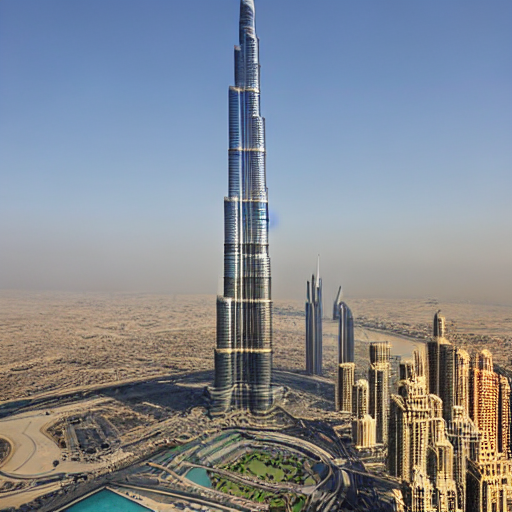

In [6]:
prompt = "burj khalifa"
with autocast(device):
  image = pipe(prompt).images[0]  
image

#Customizing the Pipelines

We'll be loading the model part by part

In [7]:
# Load the autoencoder
vae = AutoencoderKL.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='vae', use_auth_token=True)
vae = vae.to(device)

# Tokenizer (text into tokens that goes through the CLIP encoder)
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)

# UNet
unet = UNet2DConditionModel.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='unet', use_auth_token=True)
unet = unet.to(device)

# Scheduler (to perform denoising steps)
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.17.mlp.fc2.bias', 'vision_model.encoder.layers.17.self_attn.q_proj.weight', 'vision_model.encoder.layers.4.mlp.fc2.bias', 'vision_model.encoder.layers.8.self_attn.q_proj.bias', 'vision_model.encoder.layers.4.mlp.fc2.weight', 'vision_model.encoder.layers.14.layer_norm2.weight', 'vision_model.encoder.layers.17.self_attn.q_proj.bias', 'vision_model.encoder.layers.14.self_attn.v_proj.weight', 'vision_model.encoder.layers.16.self_attn.out_proj.bias', 'vision_model.encoder.layers.1.mlp.fc2.bias', 'vision_model.encoder.layers.23.self_attn.out_proj.weight', 'vision_model.post_layernorm.bias', 'vision_model.encoder.layers.13.mlp.fc1.bias', 'vision_model.encoder.layers.22.self_attn.k_proj.weight', 'vision_model.encoder.layers.10.mlp.fc2.weight', 'vision_model.encoder.layers.11.layer_norm1.weight', 'vision_model.encoder.layers.14.layer_norm1.weight', '

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

In [13]:
def get_text_embeds(prompt):
  # Tokenize text and get embeddings
  text_input = tokenizer(
      prompt, padding='max_length', max_length=tokenizer.model_max_length,
      truncation=True, return_tensors='pt')
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0] #run the text through encoder and get embeddings

  # Do the same for unconditional embeddings
  uncond_input = tokenizer(
      [''] * len(prompt), padding='max_length',
      max_length=tokenizer.model_max_length, return_tensors='pt')
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

  # Cat for final embeddings
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings

test_embeds = get_text_embeds(['happy cat'])
print(test_embeds)
print(test_embeds.shape)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],

        [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.9652, -2.4740,  0.9514,  ...,  0.4029, -0.3999, -1.2201],
         [-0.7884,  1.2808,  1.2613,  ..., -2.3532, -0.4136, -0.3192],
         ...,
         [-1.6277, -0.1600, -0.1941,  ...,  0.8261,  0.2530, -1.9380],
         [-1.6112, -0.1517, -0.1911,  ...,  0.8401,  0.2570, -1.9499],
         [-1.6338, -0.1067, -0.1505,  ...,  0.8297,  0.2626, -1.9471]]],
       device='cuda:0')
torch.Size([2, 77, 768])


In [26]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None):
  if latents is None:
    #generates random latents
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(device)


  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.sigmas[0]

  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes
      latent_model_input = torch.cat([latents] * 2)

      latent_model_input = scheduler.scale_model_input(latent_model_input, t)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, t, latents).prev_sample
  
  return latents

test_latents = produce_latents(test_embeds)
print(test_latents)
print(test_latents.shape)

0it [00:00, ?it/s]

tensor([[[[-9.0843e-01, -2.5097e-01,  3.8032e-01,  ...,  1.2670e-01,
           -5.6292e-01, -2.0890e-01],
          [-2.5441e-01, -6.1627e-01, -3.4243e-02,  ..., -5.9986e-01,
           -5.5367e-01,  9.6497e-02],
          [-5.2833e-01, -1.0649e+00,  7.0251e-02,  ..., -6.6789e-01,
            3.4907e-01, -8.8185e-02],
          ...,
          [-1.6543e+00, -1.3137e+00, -5.0386e-01,  ..., -1.7271e+00,
           -1.3511e+00,  9.1365e-01],
          [-7.3471e-02, -1.5973e+00, -5.0779e-01,  ..., -8.0686e-01,
            1.1388e-01, -1.4270e+00],
          [-1.5820e+00, -1.1718e+00, -1.0907e+00,  ..., -9.0875e-01,
           -9.8213e-01, -1.0435e+00]],

         [[-1.8602e-01, -5.0553e-01, -1.1639e+00,  ...,  1.4632e-01,
           -6.8605e-01, -2.7628e-01],
          [-1.6650e-01, -9.9941e-01, -5.1028e-01,  ..., -8.3487e-01,
           -2.3784e-01,  1.5573e-01],
          [ 1.5521e-02, -5.1350e-01, -3.6773e-02,  ..., -3.5594e-01,
           -8.4299e-01, -4.5461e-01],
          ...,
     

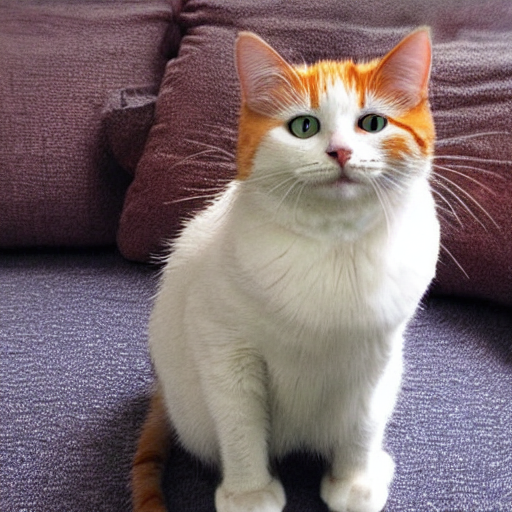

In [27]:
def decode_img_latents(latents):
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    image = vae.decode(latents).sample

  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

imgs = decode_img_latents(test_latents)
imgs[0]